### Stock Price Prediction with an LSTM

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

                Date   Close
0  1/3/2023 16:00:00  125.07
1  1/4/2023 16:00:00  126.36
2  1/5/2023 16:00:00  125.02
3  1/6/2023 16:00:00  129.62
4  1/9/2023 16:00:00  130.15


<Axes: >

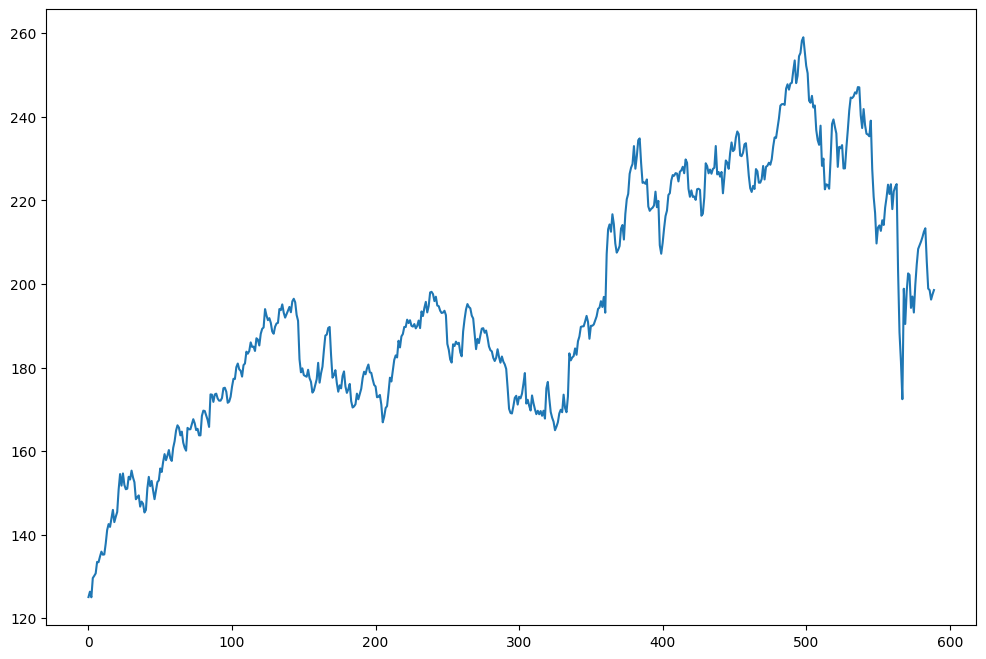

In [14]:
device = torch.device('cpu')

# Import data
url = "https://docs.google.com/spreadsheets/d/1nMJuhqiAXPth_UIF1kSkX_a2ZGiNSQD6labDfU5zLic/export?format=csv"
df = pd.read_csv(url)
print(df.head())

# Plot data
df.Close.plot(figsize=(12,8))

Data Preprocessing

In [15]:
new_data = []
for i in df["Close"]:
    new_data.append([i])
print(len(new_data))
print(new_data[10:15])

 # Gives data a mean of 0 and standard deviation of 1.
scaler = StandardScaler()

# Apply to closing price.
scaled_data = scaler.fit_transform(new_data)

print(scaled_data[10:15])

590
[[135.21], [135.27], [137.87], [141.11], [142.53]]
[[-2.05884512]
 [-2.05676943]
 [-1.96682282]
 [-1.8547355 ]
 [-1.80561082]]


In [16]:
# Create data suitable for neural network input.
seq_length = 30 # Will use the 29 days to predict the 30th day.
data = []

for i in range(len(df) - seq_length):
    # Add each range of 30 days, with overlapping sequences.
    data.append(scaled_data[i:i+seq_length])

data = np.array(data)

train_size = int(0.8 * len(data)) # Calculate 80% of dataset to be training data.

# All but last day. [80% of data, all but last day]
X_train = torch.from_numpy(data[:train_size, :-1]).type(torch.Tensor).to(device)
# All but last day. [80% of data, last day]
Y_train = torch.from_numpy(data[:train_size, -1]).type(torch.Tensor).to(device)

# All but last day. [Last 20% of data, all but last day]
X_test = torch.from_numpy(data[train_size:, :-1]).type(torch.Tensor).to(device)
# All but last day. [Last 20% of data, last day]
Y_test = torch.from_numpy(data[train_size:, -1]).type(torch.Tensor).to(device)

In [11]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(PredictionModel, self).__init__()

    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1])

    return out

In [17]:
# Create model
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

# Define loss and optimizer.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
# Train the model
epochs = 200

for i in range(epochs):
    Y_train_pred = model(X_train)

    loss = criterion(Y_train_pred, Y_train)

    if i % 25 == 0:
    print(f"On epoch {i}, loss: {loss}")

    optimizer.zero_grad() # Zero gradients.
    loss.backward() # Backpropagate the loss.
    optimizer.step() # Optimise weights.

On epoch 0, loss: 0.6902784705162048
On epoch 25, loss: 0.02032795362174511
On epoch 50, loss: 0.014397467486560345
On epoch 75, loss: 0.011825693771243095
On epoch 100, loss: 0.010303354822099209
On epoch 125, loss: 0.009166263975203037
On epoch 150, loss: 0.008372376672923565
On epoch 175, loss: 0.007894966751337051


Evaluate the trained model.

In [20]:
model.eval()

Y_test_pred = model(X_test)
# Inverse scaling, detach from CPU and convert to a numpy array.
Y_train_pred = scaler.inverse_transform(Y_train_pred.detach().cpu().numpy())
Y_train = scaler.inverse_transform(Y_train.detach().cpu().numpy())
Y_test_pred = scaler.inverse_transform(Y_test_pred.detach().cpu().numpy())
Y_test = scaler.inverse_transform(Y_test.detach().cpu().numpy())

In [22]:
# Using RMSE to calculate error.
train_rmse = root_mean_squared_error(Y_train[:, 0], Y_train_pred)
test_rmse = root_mean_squared_error(Y_test[:, 0], Y_test_pred)

In [23]:
# Margin of error roughly in dollars.
print("Train RMSE:", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE: 2.5251660346984863
Test RMSE:  6.672002792358398


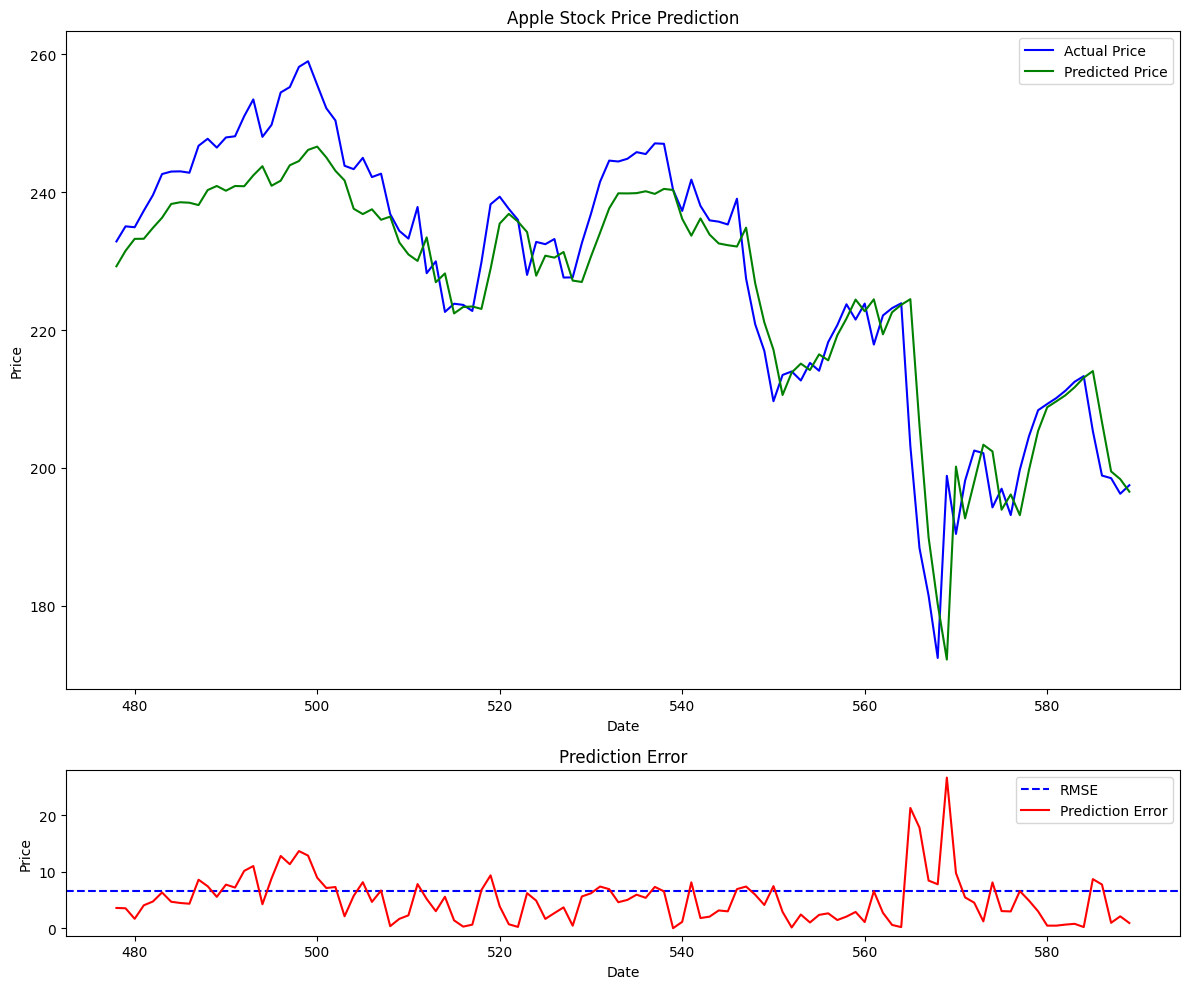

In [24]:
# Graph the predictions and prediction errors.
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(Y_test):].index, Y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(Y_test):].index, Y_test_pred, color='green', label='Predicted Price')
ax1.legend()
plt.title("Apple Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label="RMSE")
ax2.plot(df[-len(Y_test):].index, abs(Y_test - Y_test_pred), color='r', label='Prediction Error')
ax2.legend()
plt.title("Prediction Error")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()